# Описание проекта
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

# Задачи
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

# Описание данных 
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент  в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

# Шаг 1. Загрузка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import seaborn as sns, numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym.info() # с данными все в порядке 14 колонок, пропусков нет, тип данных выглядит нормальным

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
gym.columns = gym.columns.str.lower() # приведем названия столбцов к нижнему регистру

# Шаг 2. Проведите исследовательский анализ данных (EDA)

## Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe())

In [5]:
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
gym['gender'].describe() # распределение по полу почти 50/50, стандартное отклонение 0.5

count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

In [7]:
gym['near_location'].describe() # примерно 84% клиентов проживает в одной районе с фитнес центром, стандартное отклонение 0.36

count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_location, dtype: float64

In [8]:
gym['partner'].describe() # почти половина клиентов это сотрудники компании-партнёра клуба, стандартное отклонение 0.5

count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64

In [9]:
gym['promo_friends'].describe() # примерно 30% использовали промо-код от знакомого при оплате первого абонемента, стандартное отклонение 0.46

count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64

In [10]:
gym['phone'].describe() # 90% клиентов указали телефон, стандартное отклонение 0.29

count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: phone, dtype: float64

In [11]:
gym['contract_period'].describe() #Средняя длительность текущего абонемента - 4-5 месяцев, медиана - 1 месяц. 
# возможно, присутствуют выбросы. Максимальное значение - 12 месяцев, стандартное отклонение 4.5

count    4000.000000
mean        4.681250
std         4.549706
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: contract_period, dtype: float64

In [12]:
gym['group_visits'].describe() # 41% клиентов посещают групповые занятия. Стандартное отклонение - 0.49.

count    4000.000000
mean        0.412250
std         0.492301
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: group_visits, dtype: float64

In [13]:
gym['age'].describe() # Максимальный возраст клиентов - 41 год, медиана и среднее значение  - 29 лет, Минимальный возраст клиентов - 18 лет.
# скорее всего, с распределением возрастов все в порядке.

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64

In [14]:
gym['avg_additional_charges_total'].describe() #суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон. 

count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64

Суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон, в среднем 147 у.е., Максимальный размер трат - 552 у.е. медианное и среднее достаточно близки 136 и 147 у.е., стандартное отклонение достаточно большое - 96.3


In [15]:
gym['month_to_end_contract'].describe()

count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: float64

Медианный срок до окончания текущего действующего абонемента - 1 месяц, средний - 4 месяца. Следовательно на среднее значение имеют влияние выбросы. Помимо этого можно заметить, что клиентов у которых абонемент подходит к концу больше чем тех, у кого он только начался.


In [16]:
gym['lifetime'].describe()

count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: lifetime, dtype: float64

Большинство клиентов обратились в фитнес-центр около 3-х месяцев назад. Максимальное значение - 31 месяц

In [17]:
gym['avg_class_frequency_total'].describe()

count    4000.000000
mean        1.879020
std         0.972245
min         0.000000
25%         1.180875
50%         1.832768
75%         2.536078
max         6.023668
Name: avg_class_frequency_total, dtype: float64

Средняя частота посещения фитнес-центра 1-2 раза в неделю, максимальное значение 6 раз. Стандартное отклонение - 0.97

In [18]:
gym['avg_class_frequency_current_month'].describe()

count    4000.000000
mean        1.767052
std         1.052906
min         0.000000
25%         0.963003
50%         1.719574
75%         2.510336
max         6.146783
Name: avg_class_frequency_current_month, dtype: float64

Средняя частота посещений за последний месяц достаточно близка к общей

In [19]:
gym['churn'].describe()

count    4000.000000
mean        0.265250
std         0.441521
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64

Отток в текущем месяце составил 26%. Стандартное отклонение - 0.44.

In [20]:
display(gym.agg(['mean','std'])) # выведем средние значения и стандартное отклонение в одну таблицу

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521


In [21]:
gym[gym.duplicated()] # проверим дубликаты

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn


## Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());

In [22]:
display(gym.groupby('churn')['gender'].agg('count'))

churn
0    2939
1    1061
Name: gender, dtype: int64

Ушло -  1061 клиент , осталось 2939

In [23]:
display(gym.groupby('churn').agg('mean'))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


- По полу примерное равное количество клиентов ушло и осталось
- 76% тех кто ушел жили или работали в одном районе с фитнес центром
- 35% тех кто ушел были сотрудники компании-партнёра клуба
- 18% тех кто ушел записывались в рамках акции «приведи друга».
- по телефону ситуация равная 90% для обеих групп
- 26% ушедших посещали групповые занятия , а осталось 46%
- возраст для обеих групп 26-30 лет
- Среди ушедших траты 115 у.е., а среди оставшихся 158 у.е.
- Среди ушедших большинство ушло в течение месяца, значит есть проблемы с удержанием клиента
- Среди ушедших посещения примерно 1 раз в неделю, а среди оставшихся больше 2 раз

## Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

In [24]:
def hist_out(i):
    gym_one = gym[gym['churn'] == 1]
    gym_zero = gym[gym['churn'] == 0]
    plt.figure(figsize = (9, 3.5))
    sns.distplot(gym_one[i])
    sns.distplot(gym_zero[i])
    plt.legend(labels=['Ушедшие', 'Оставшиеся'], fontsize = 12)
    plt.title(i, fontsize=12);

In [25]:
list_columns = gym.columns.tolist()
display(list_columns[:-1])

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month']

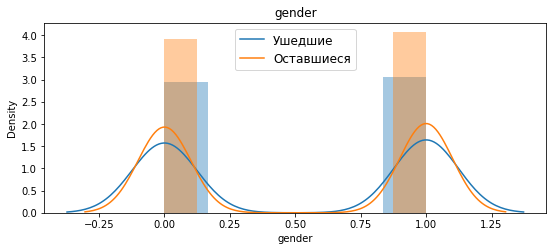

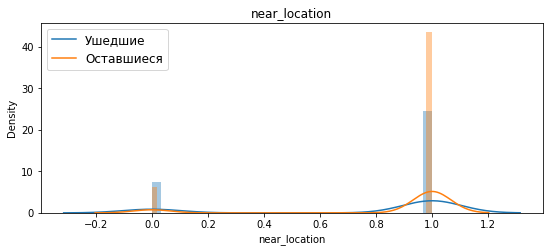

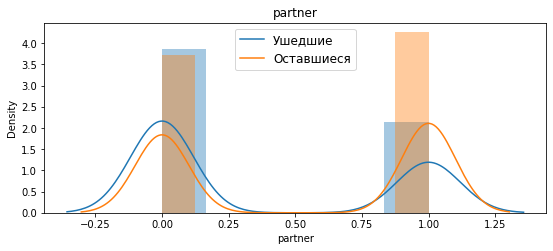

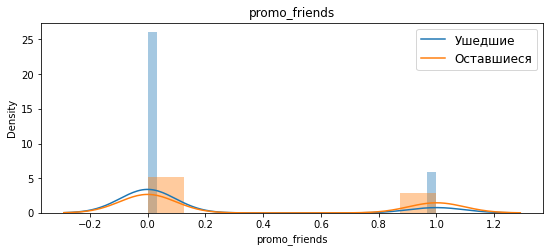

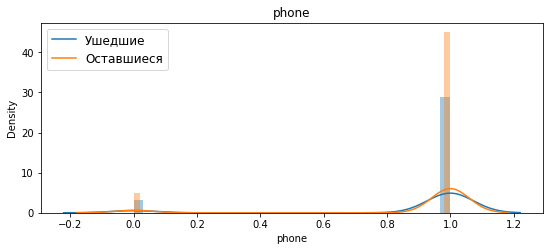

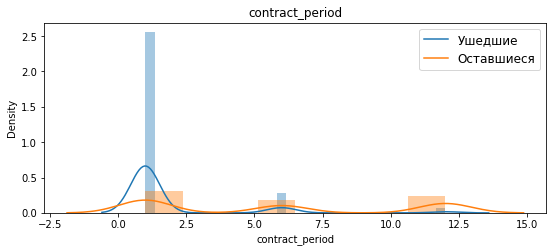

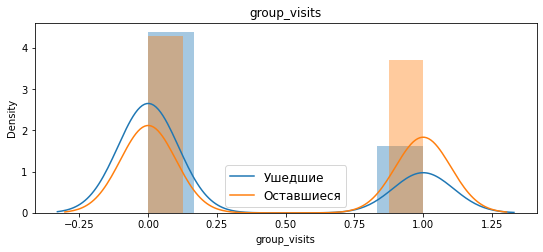

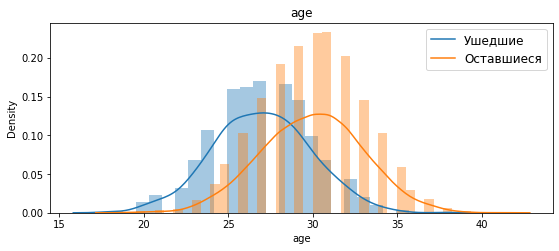

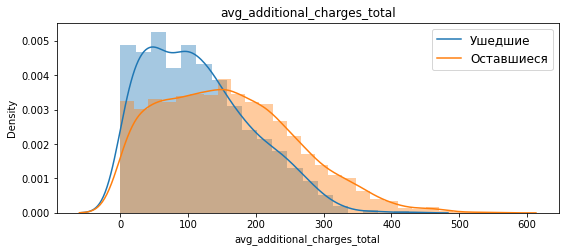

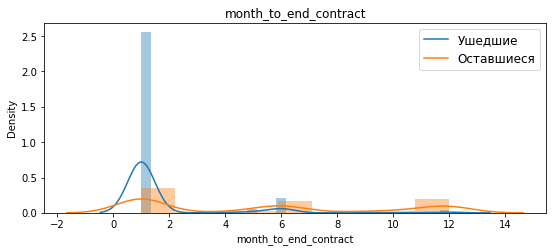

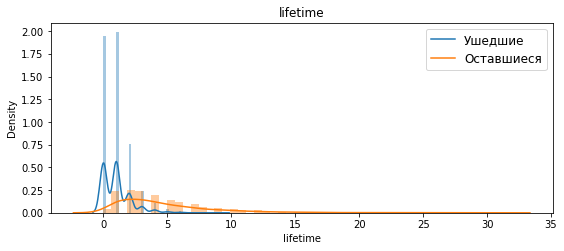

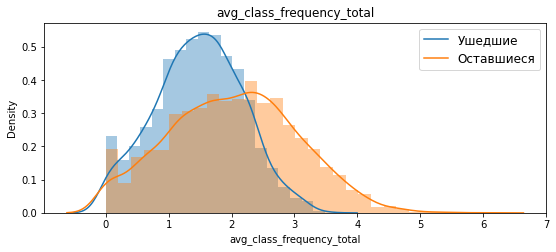

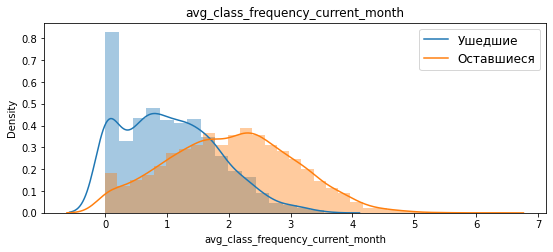

In [26]:
for i in list_columns[0:13]:
    hist_out(i)

## Постройте матрицу корреляций и отобразите её.

In [27]:
gym.corr().style.background_gradient()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


In [28]:
gym = gym.drop(columns=['contract_period', 'avg_class_frequency_current_month']) # #исключим мультиколлинеарность, чтобы не мешало в обучении модели 

Клиенты пришедшие по промо коду от друзей и сотрудники компании-партнёра клуба занимаются в зале дольше других

# Шаг 3. Постройте модель прогнозирования оттока клиентов

# Разбейте данные на обучающую и валидационную выборку функцией train_test_split().

In [29]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop(columns=['churn'])
y = gym['churn']
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Обучите модель на train-выборке двумя способами:логистической регрессией и случайным лесом.

In [30]:
# зададим список моделей
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0)
]

# построим функцию, которая принимает на вход модель и данные и выводит метрики
def predict_model(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )

## Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

In [31]:
for i in models:
    print(i)
    predict_model(
        m=i,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

LogisticRegression(random_state=0)
Accuracy:0.88 Precision:0.75 Recall:0.74
RandomForestClassifier(random_state=0)
Accuracy:0.90 Precision:0.80 Recall:0.77


Обе модели имеют хороший показатель правильных ответов, 88% на логистической регрессии и 90% случайным лесом. Над точностью и полнотой еще следует поработать.

# Шаг 4. Сделайте кластеризацию клиентов

# Стандартизируйте данные.

In [32]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

# Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.

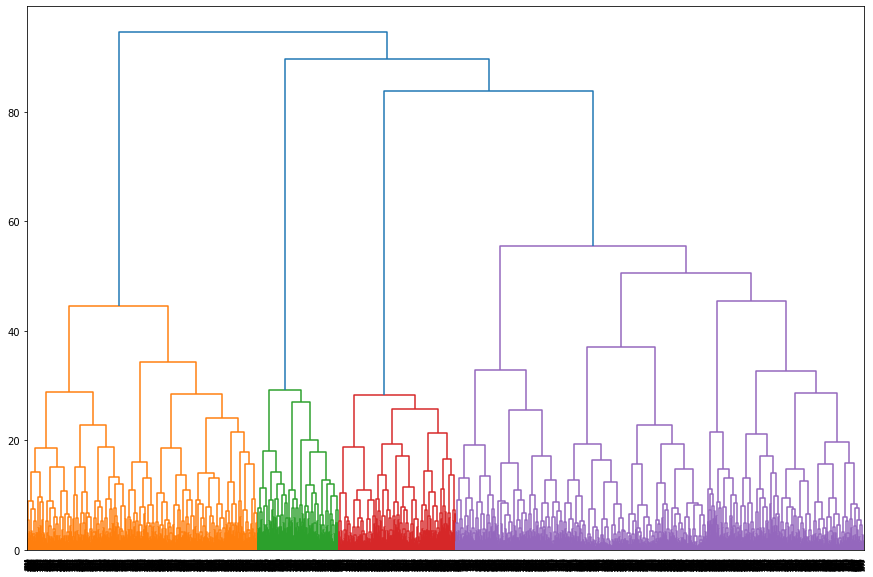

In [33]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Можно выделить 4 кластера. поскольку 4-ый кластер очень объемный, будем считать выборку по 5-ю кластерам

# Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).

In [34]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

# Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [35]:
# сохраняем метки кластеров
gym['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
gym.groupby('cluster_km').agg('mean')

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,churn
cluster_km,,,,,,,,,,,,
0,0.498501,0.995005,0.889111,1.000000,1.0,0.519481,29.543457,152.139417,6.265734,4.210789,1.951909,0.132867
1,0.500898,0.000000,0.488330,0.077199,1.0,0.231598,28.685817,137.277472,2.804309,2.978456,1.762672,0.402154
2,0.521158,0.995546,0.417595,0.011136,1.0,0.546771,30.805122,177.103564,6.162584,5.701559,2.318701,0.016704
3,0.512090,1.000000,0.196891,0.053541,1.0,0.297064,27.818653,124.625600,1.898964,2.058722,1.539284,0.506045
4,0.523316,0.862694,0.471503,0.305699,0.0,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,0.266839


1. Клиенты в нулевом кластере - живут или работают рядом с клубом, а также  пришли по акции друзей. Большинство - это сотрудники компании-партнёра клуба. Ходят в клуб около 4-х месяцев, на дополнительные услуги тратят - 152 у.е., до конца абонемента осталось около 6 месяцев. Частота посещения около 2-х раз в неделю.
2. Клиенты в первом кластере - пришли не по акции друзей, живут или работают далеко от клуба и почти не ходят на групповые занятия. Отток таких клиентов примерно 40%
3. Клиенты во втором кластере -  живут или работают близко к клубу, пришли не по акции друзей. Средний возраст - 31 год, на дополнительные услуги тратят около - 177 у.е.,  до конца абонемента осталось около 6-ти месяцев. Посещают зал примерно 2 раза в неделю . Отток примерно 1%.
4. Клиенты в третьем кластере -  живутили работают около клуба. Большинство - это не сотрудники компании-партнёра клуба и пришли не по акции друзей. Редко посещают групповые занятия,  тратят на доп. услуги в клубе примерно - 124 у.е., до конца абонемента осталось около 2-х месяцев, начали заниматься недавно. Отток примерно 50%.
5. Клиенты в 4-м кластере - не дали номер телефона. Живут или работаютблизко к клубу, половина из клиентов - сотрудники компании-партнёра клуба. До конца абонемента примерно 4 месяца, отток примерно 26%.

# Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

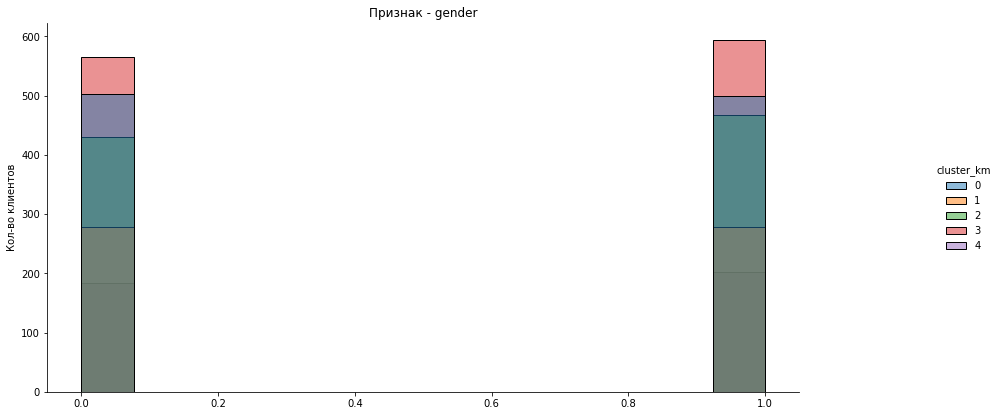

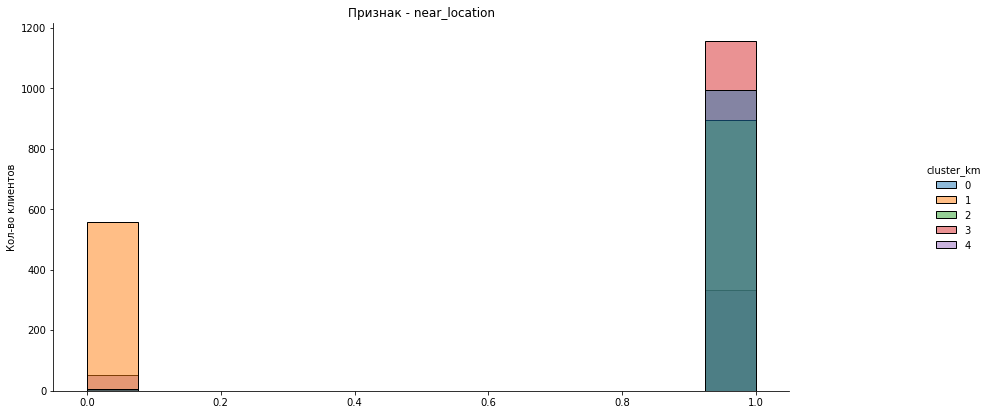

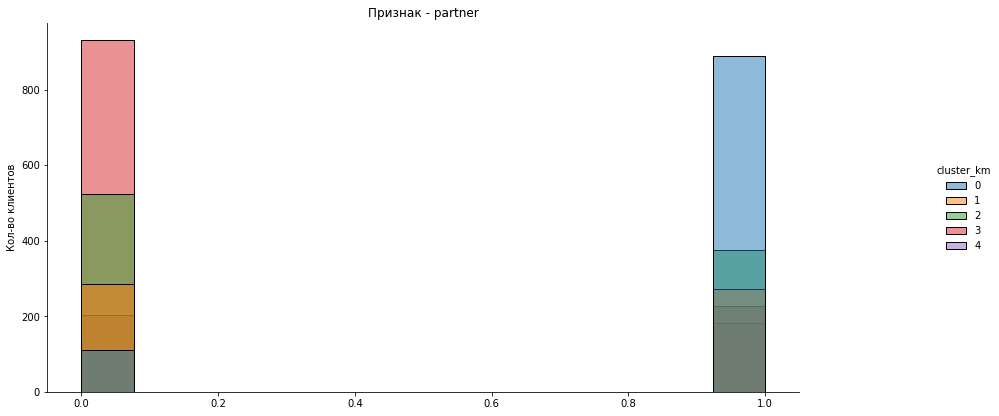

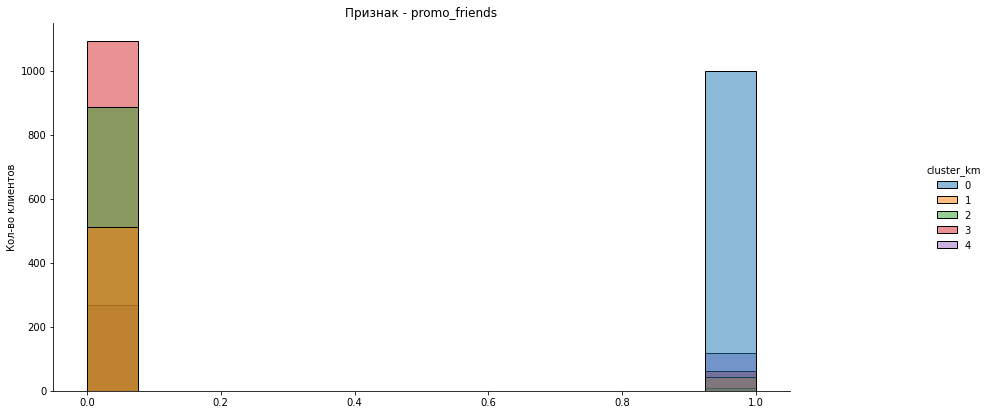

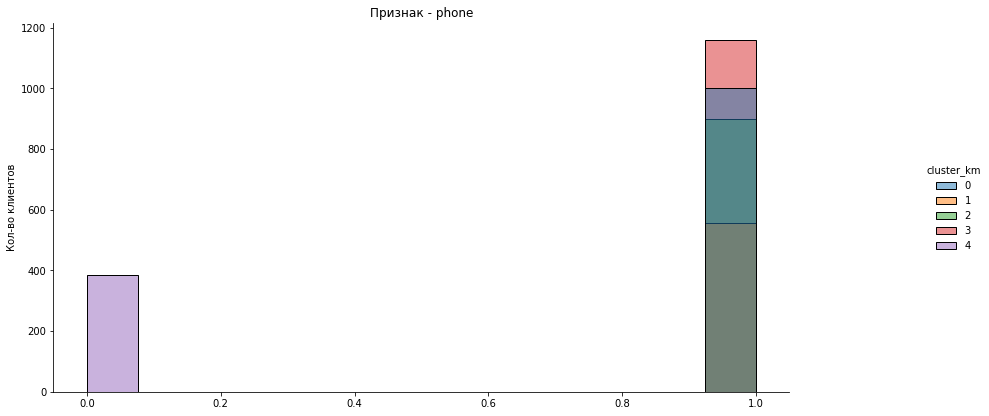

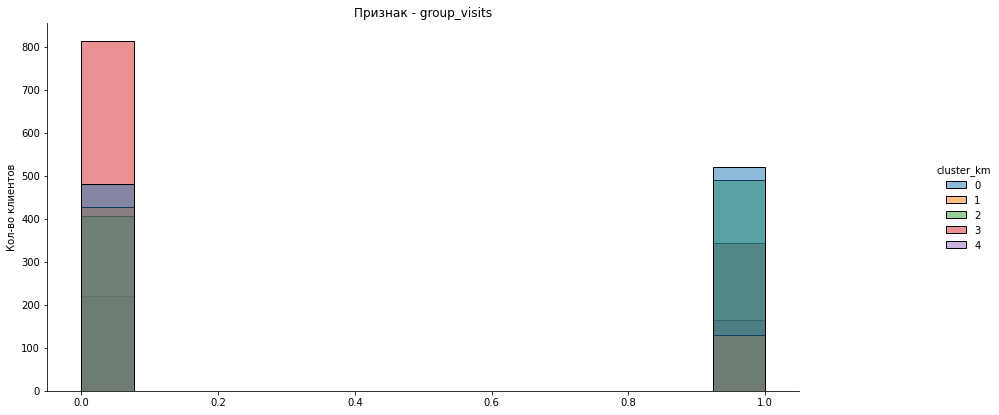

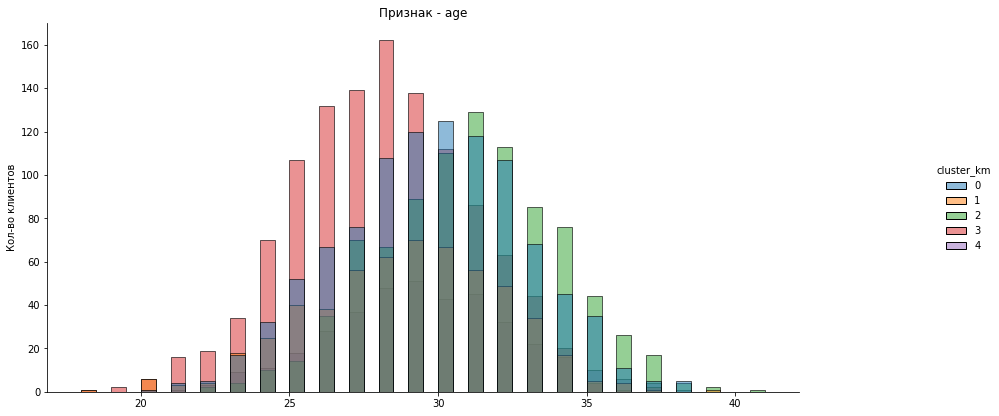

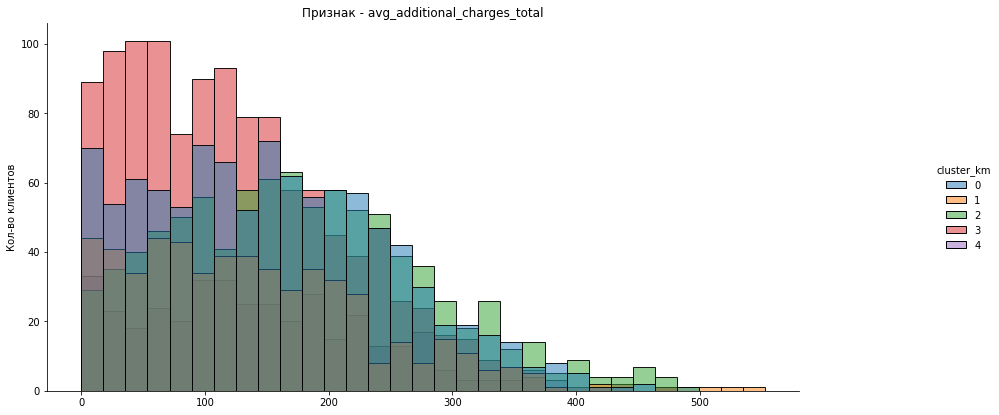

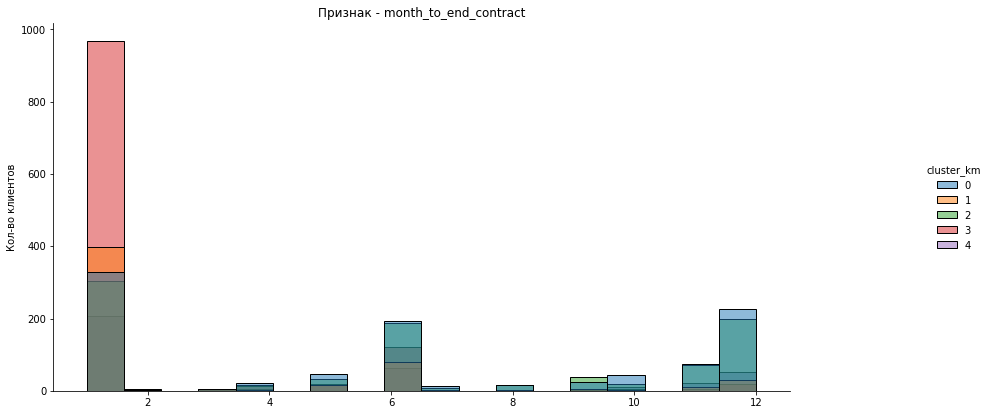

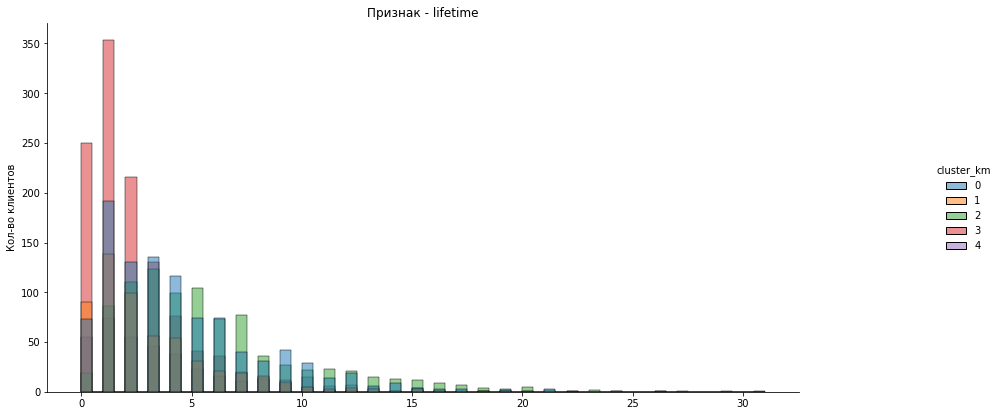

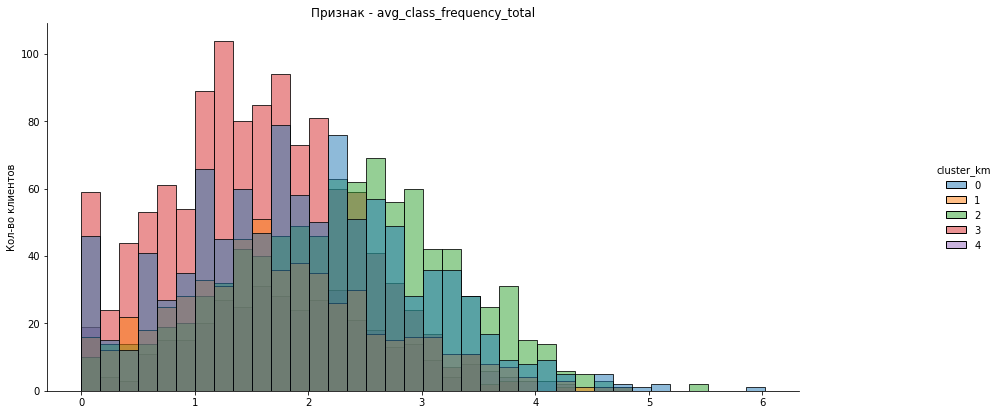

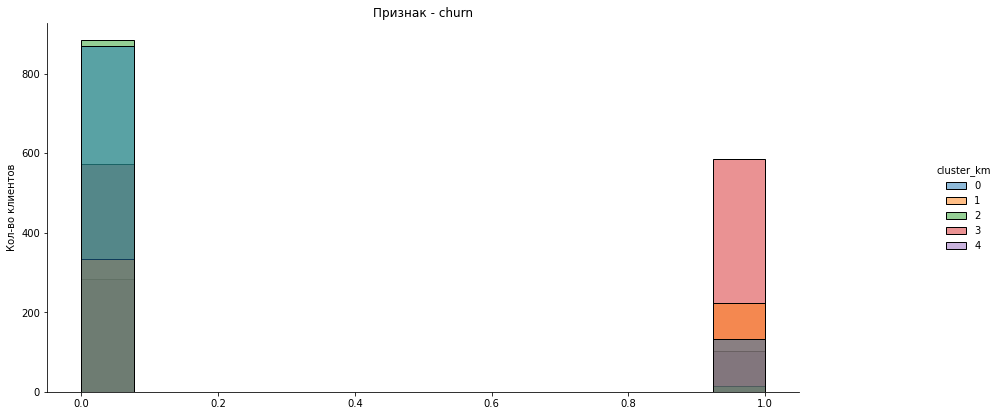

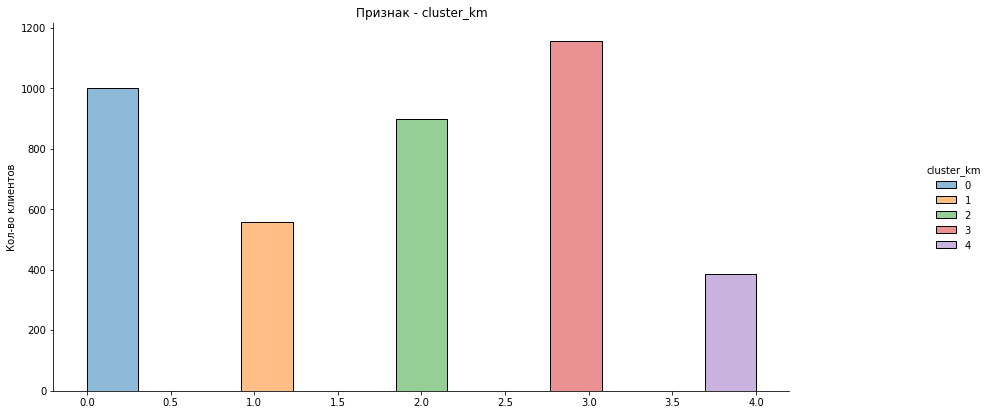

In [39]:
for f in gym:
    g = sns.displot(gym, x=gym[f], hue='cluster_km', palette="tab10", kind='hist' ) 
    plt.title(f'Признак - {f}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("")
    g.fig.set_figwidth(15)
    g.fig.set_figheight(6)
    g.fig.patch.set_linewidth(5)

- 'gender' - нет ничего особенного
- 'near_location' - В кластерах 0, 2, 3, 4 клиенты проживают или работают в районе, где находится фитнес-ценр. Кластер 1 содержит клиентов, которые живут в других районах, то есть, дальше от центра.
- 'partner'- В кластере 0 большая часть клиентов  - сотрудники компании-партнёра клуба. В кластерах 1, 2 и 4 почти половина клиентов - это сотрудники компании-партнёра клуба. В кластере 3 сосредоточились клиенты, в большинстве своём не являющиеся сотрудниками партнеров клуба.
- 'promo_friends' - В кластерах 1, 2 и 3 содержится информация о клиентах, которые в большинстве своем пришли в клуб не по акции. В кластере 0 находятся клиенты, пришедшие по акции «приведи друга».
- 'phone' - В кластере 4 клиенты не оставившие номер телефона
- 'group_visits' - Большинство клиентов из кластеров 1,3,4 не ходили на групповые занятия. Из кластеров 0 и 2 половина ходила, а половина нет
- 'age' - Распределение возраста по кластером достаточно равномерное, в районе 28-30 лет
- 'avg_additional_charges_total' - Меньше всего трат в кластере 3, чуть больше остальных у кластеров 0 и 2
- 'month_to_end_contract' - До окончания абонемента меньше всего времени у кластера 3 (около 2 месяцев), больше всего у кластеров 0 и 2 - приблизительно 6 месяцев
- 'lifetime' - Время с момента первого посещения у кластера 3 около 2 месяцев, у кластеров 0 и 2 около 5 месяцев
- 'avg_class_frequency_total' - Самая низкая средняя частота посещений у кластера 2 - около 2 раз в неделю 
- 'churn' - В 0 и 2 кластерах отток клиентов меньше, чем в 1 и 3

# Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [37]:
#посчитаем долю оттока
churn_share = gym.groupby('cluster_km')['churn'].agg('sum') / gym.groupby('cluster_km')['churn'].size()
display(churn_share)

cluster_km
0    0.132867
1    0.402154
2    0.016704
3    0.506045
4    0.266839
Name: churn, dtype: float64

Более склонны к оттоку кластеры 1 и 3 (ушло 40-50% клиентов), наиболее надежны кластеры 0 и 2 ( ушло 1-13% клиентов)

# Шаг 5. Выводы и базовые рекомендации по работе с клиентами

После анализа данных сети фитнес-центров «Культурист-датасаентист», можно сделать следующие выводы:

Сформированы 3 основные группы клиентов:

- 1 группа - клиенты жувут или работают рядом с клубом, имеют малый отток, порядка 13%, большинство пришли по акции приведи друга или от компании-партнера, половина клиентов посещает групповые занятия , тратят примерно 150 у.е. на дополнительные услуги, занимаются уже около 4-х месяцев.
- Также клиенты живущие близко к клубу, пришедшие не по акции приведи друга, со средней активностью посещают групповые занятия, до конца абонемента осталось около 6 месяцев. Средняя частота посещения примерно 2 раза в неделю.

- 2 группа - Клиенты живущие или работающие в другом районе, имеют отток примерно 40%, пришли не по акции приведи друга, почти не посещают групповые занятия и состоят в клубе примерно 3 месяца.

- 3 группа - Большинство клиентов пришло не по акции приведи друга, имеют отток примерно 50%, мало посещают групповые занятия, тратят на доп. услуги примерно 120 у.е., до конца абонемента осталось около 2 месяцев, при этом начали заниматься недавно.

Выводы на основании этих групп:

- У клиентов пришедших не по акции приведи друга, больше вероятность раньше забросить фитнес-центр, таких клиентов следует заинтересовать групповыми занятиями, т.к. коллективные занятия помогут стимулировать желание продолжать заниматься
- Если клиент стал реже ходить на групповые занятия увеличивается вероятность, что клиент уйдет
- Нужно больше внимания уделять новым клиентам, т.к. среди них отток наиболее вероятен
- Также клиенты живущие далеко от фитнес-центра имеют большую вероятность забросить посещение клуба.

Рекомендации по удержанию клиента:
- Предлагать более выгодные цены на абонементы на 12 месяцев
- Предлагать различные партнерсик программы и промо-акции
- Создать более приятную атмосферу, чтобы клиенты ходили в клуб чаще 2-3 раз в неделю
- Активнее завлекать клиентов участвовать в групповых занятиях